In [ ]:
# install and import required dependencies

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import nltk
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import clear_output, display
from google.colab import drive
import random
!pip install datasets transformers
clear_output()
from datasets import load_dataset, set_caching_enabled
from transformers import TrainingArguments,AutoFeatureExtractor,AutoModel,Trainer,logging,AutoTokenizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/VQA/dataset


/content/drive/.shortcut-targets-by-id/1gPz2_T8cKL4flJzBsjzX_v6wnQSi_OYx/VQA/dataset


In [ ]:
!cp -r '/content/drive/.shortcut-targets-by-id/1gPz2_T8cKL4flJzBsjzX_v6wnQSi_OYx/VQA/' '/content/drive/MyDrive/copy-VQA/'


In [ ]:
%cd /content/drive/MyDrive/copy-VQA/dataset


/content/drive/MyDrive/copy-VQA/dataset


In [ ]:
# set the GPU device
device = torch.device('cuda')
# save the csv files inside the dataset using load_daset function of 'dataset' library
dataset = load_dataset("csv", data_files={"train": "data_train.csv","test": "data_eval.csv"})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f142ed9115826340/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# answer_space.txt file contains all the possible answer list
with open("answer_space.txt") as f:
    all_answers = f.read().splitlines()

def process_answer(answer):
    # Select the 1st answer if multiple answers are provided
    answer = answer.replace(" ", "")
    if "," in answer:
        answer = answer.split(",")[0]
    return all_answers.index(answer)

def transform_example(example):
    label = [process_answer(ans) for ans in example['answer']]
    return {'label': label}
# add an extra feature -> 'label' (corresponding index in the answer_space.txt) to the dataset
dataset = dataset.map(transform_example, batched=True)

dataset

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

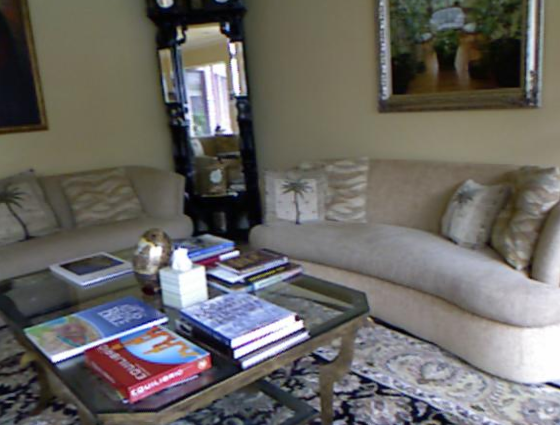

Question: what object is below the table
Answer: floor_mat (Label: 221)


In [ ]:
# let's see an example from the dataset selected randomly
def dataset_example(train_data=True, example_id=None):
    if train_data:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if example_id is not None:
        example_id = example_id
    else:
        example_id = random.randint(0, len(data) - 1)

    image_id = data[example_id]["image_id"]
    image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
    image = Image.open(image_path)
    display(image)

    question = data[example_id]["question"]
    answer = data[example_id]["answer"]
    label = data[example_id]["label"]
    print("Question: " + str(question))
    print("Answer: " + str(answer) + " (Label: " + str(label) + ")")
dataset_example()

In [ ]:
# The code for the function wup_measure is taken from -> https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py
# WUPS is a measure of semantic similarity between predicted and ground truth labels based on WordNet, a lexical database of English
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [ ]:
# this function will return mean after calculating all the wup score of respective words in the labels and preds list
def wup_measure_for_batch(labels1, labels2):
    wup_scores = []
    for i in range(len(labels1)):
        label1, label2 = labels1[i], labels2[i]
        wup_score = wup_measure(all_answers[label1], all_answers[label2])
        wup_scores.append(wup_score)
    return np.mean(wup_scores)


In [ ]:
# Let us see that what wups score we get for completely random pairs and exactly same words
S1 = np.random.randint(len(all_answers), size=5)
S2 = np.random.randint(len(all_answers), size=5)
print([all_answers[id] for id in S1])
print([all_answers[id] for id in S2])
print("WUP for two completely unrelated label sequences: ", wup_measure_for_batch(S1, S2))
print("WUP for two same label sequences: ", wup_measure_for_batch(S1, S1))

['container', 'toys_shelf', 'window', 'hockey_glove', 'window']
['board', 'ceiling', 'vessel_set', 'counter', 'shelf_frame']
WUP for two completely unrelated label sequences:  0.015000000000000003
WUP for two same label sequences:  1.0


In [ ]:
# computes evaluation metrics for a given set of predicted labels and ground truth labels
def compute_metrics(to_evaluate):
    predicted_labels, labels = to_evaluate
    best_predicted = np.argmax(predicted_labels, axis=-1)
    wups = wup_measure_for_batch(labels, best_predicted)
    accuracy = accuracy_score(labels, best_predicted)
    f1 = f1_score(labels, best_predicted, average='macro')
    return {"wups": wups, "acc": accuracy, "f1": f1}


In [ ]:
@dataclass
class OverallExtractor:
    # A OverallExtractor class that will be used to process the raw batch dictionary before feeding it into the model.

    # The tokenizer object that will be used to tokenize the text data.
    MyTokenizer: AutoTokenizer                                      ########################################################
    # The feature extractor object that will be used to process the image data.
    MyFeatureExtractor: AutoFeatureExtractor

    def __call__(self, RawBatch):
        # Processes the raw batch dictionary by tokenizing the text data and preprocessing the image data.

        # Extracts the required data from the raw batch dictionary.
        question_list = RawBatch['question'] if isinstance(RawBatch, dict) else [i['question'] for i in RawBatch]
        image_id_list = RawBatch['image_id'] if isinstance(RawBatch, dict) else [i['image_id'] for i in RawBatch]
        label_list = RawBatch['label'] if isinstance(RawBatch, dict) else [i['label'] for i in RawBatch]

        # Tokenizes the text data using the provided tokenizer object.
        encoded_text = self.MyTokenizer(
            text=question_list,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        # Preprocesses the image data using the provided feature extractor object.
        processed_images = self.MyFeatureExtractor(
            images=[Image.open(os.path.join("..", "dataset", "images", image_id + ".png")).convert('RGB') for image_id in image_id_list],
            return_tensors="pt",
        )

        # Returns the processed data in a dictionary format.
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
            "pixel_values": processed_images['pixel_values'].squeeze(),
            "labels": torch.tensor(label_list, dtype=torch.int64)
        }


In [ ]:
# Inherit from the nn.Module class to create a PyTorch neural network module
class OverallVQAModel(nn.Module):

    # Constructor function to initialize the model
    def __init__(self, num_labels=len(all_answers), intermediate_dim=512, pretrained_text_name=None, pretrained_image_name=None):
        # Initialize the parent class using super() function
        super().__init__()

        # Set the number of output labels and the pretrained model names for text and image
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Load the pretrained models for text and image from Hugging Face model hub
        self.text_encoder = AutoModel.from_pretrained(pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(pretrained_image_name)

        # Define a fully connected layer for fusion of text and image embeddings
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Define a linear layer for classification
        self.classifier = nn.Linear(intermediate_dim, num_labels)

        # Define the loss function
        self.criterion = nn.CrossEntropyLoss()

    # Forward function that defines how inputs are passed through the model
    def forward(self, input_ids, pixel_values, attention_mask=None, token_type_ids=None, labels=None):

        # Pass the input text through the text encoder                              ########################################################
        encoded_text = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)

        # Pass the input image through the image encoder                            ########################################################
        encoded_image = self.image_encoder(pixel_values=pixel_values, return_dict=True)

        # Concatenate the text and image embeddings and pass them through the fusion layer
        fused_output = self.fusion(torch.cat([encoded_text.pooler_output, encoded_image.pooler_output], dim=1))

        # Pass the fused output through the classification layer
        predicted_labels = self.classifier(fused_output)

        # Return the predicted labels
        out = {"predicted_labels": predicted_labels}

        # If labels are provided, compute the loss
        if labels is not None:
            loss = self.criterion(predicted_labels, labels)
            out["loss"] = loss

        return out


In [ ]:
args = TrainingArguments(
    output_dir="checkpoint",        #The directory where the trained model and other output files will be saved
    seed=12345,
    evaluation_strategy="steps",    #Evaluation strategy for training: evaluate every eval_steps
    eval_steps=100,                 # Number of update steps between two evaluations
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32, #The batch size per GPU/CPU for training
    per_device_eval_batch_size=32,  #The batch size per GPU/CPU for evaluation
    remove_unused_columns=False,    #remove the unused columns from the dataset, Helps speed up training
    num_train_epochs=5,         #<<<<<<<----------   Epochs
    fp16=True,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    dataloader_num_workers=8,
    load_best_model_at_end=True,   #loads the best model based on the evaluation metric at the end of training
)

In [ ]:
text_model='roberta-base'
image_model='facebook/deit-base-distilled-patch16-224'
multimodal_model='robert_deit'

collator = OverallExtractor(MyTokenizer=AutoTokenizer.from_pretrained(text_model),MyFeatureExtractor=AutoFeatureExtractor.from_pretrained(image_model),)
model = OverallVQAModel(pretrained_text_name=text_model, pretrained_image_name=image_model).to(device)

# Deepcopy the args and set the output directory to the checkpoint directory
args_copy = deepcopy(args)

args_copy.output_dir = os.path.join("..", "checkpoint", multimodal_model)

"""
The Trainer function is a part of the Hugging Face's Transformers library,
 which is used to train a deep learning model on a given dataset. The Trainer
  function is a high-level API that simplifies the training process and
  provides a simple way to train, evaluate and test deep learning models.
"""

multi_trainer = Trainer(
    model,
    args_copy,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
    compute_metrics=compute_metrics
)

train_multi_metrics = multi_trainer.train()
eval_multi_metrics = multi_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker cr

Step,Training Loss,Validation Loss,Wups,Acc,F1
100,5.679300,4.926824,0.157263,0.099038,0.002746
200,4.859700,4.526238,0.164060,0.106255,0.004104
300,4.575200,4.287877,0.202702,0.145549,0.006875
400,4.313300,4.139802,0.219750,0.167602,0.011134
500,4.241600,4.014554,0.227847,0.166399,0.009178
600,4.034200,3.917836,0.248669,0.196872,0.014617
700,3.894100,3.845373,0.257536,0.204090,0.015406
800,3.857400,3.787446,0.267991,0.216921,0.018702
900,3.789000,3.725998,0.273056,0.222133,0.020246
1000,3.658400,3.672126,0.282827,0.232157,0.020654


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

In [ ]:
eval_multi_metrics

{'eval_loss': 3.5957274436950684,
 'eval_wups': 0.2885976174404253,
 'eval_acc': 0.23977546110665598,
 'eval_f1': 0.025765018140332368,
 'eval_runtime': 58.1317,
 'eval_samples_per_second': 42.903,
 'eval_steps_per_second': 1.342,
 'epoch': 5.0}

In [ ]:
model = OverallVQAModel(pretrained_text_name=text_model, pretrained_image_name=image_model) # Use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("..", "checkpoint", "robert_deit", "checkpoint-1500", "pytorch_model.bin")))
model.to(device)

In [ ]:
# with open('/content/drive/MyDrive/VQA/VQA-With-Multimodal-Transformers-main/params.yaml') as conf_file:
#         config = yaml.safe_load(conf_file)
# config["model"]["name"]

In [ ]:
MyExample = collator(dataset["test"][1200:1205])
input_ids = MyExample["input_ids"].to(device)
token_type_ids = MyExample["token_type_ids"].to(device)
attention_mask = MyExample["attention_mask"].to(device)
pixel_values = MyExample["pixel_values"].to(device)
labels = MyExample["labels"].to(device)
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)
preds = output["predicted_labels"].argmax(axis=-1).cpu().numpy()
preds

array([106, 483, 483, 381, 149])

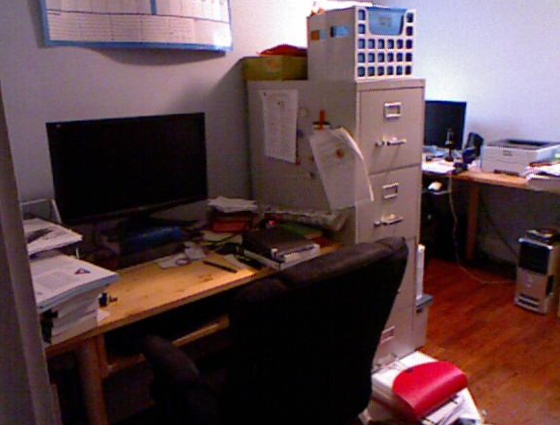

Question: what is on the right side of the table
Answer: drawer (Label: 182)
Predicted Answer:	 chair


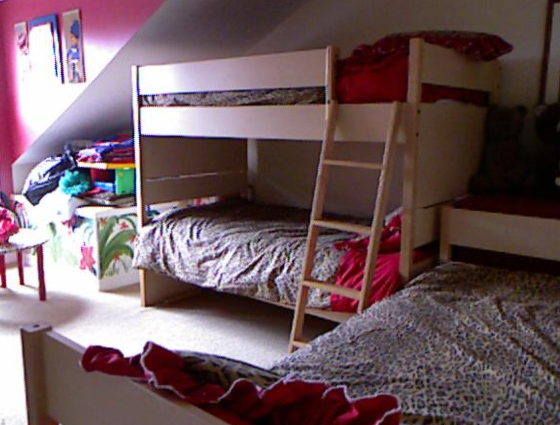

Question: what is the largest object
Answer: bunk_bed (Label: 79)
Predicted Answer:	 table


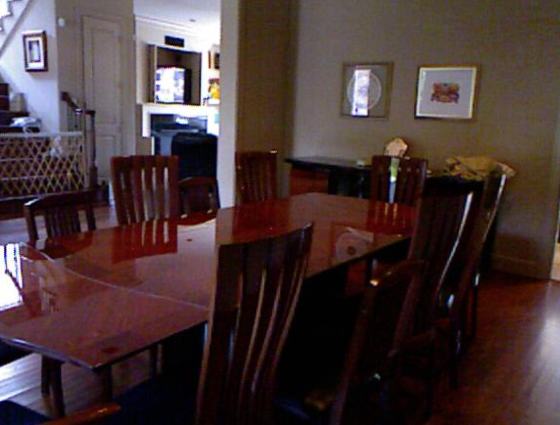

Question: what is found below the photos
Answer: cabinet (Label: 81)
Predicted Answer:	 table


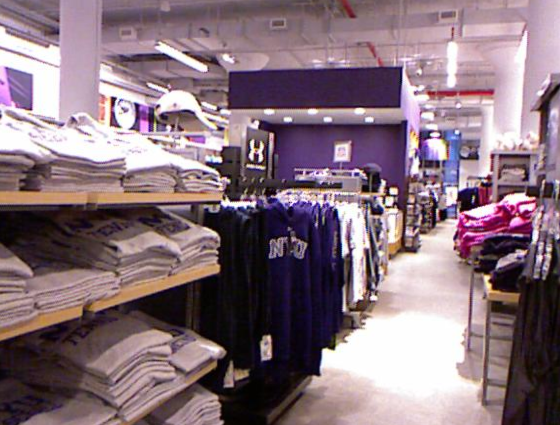

Question: what is the object close to the wall
Answer: clock (Label: 114)
Predicted Answer:	 picture


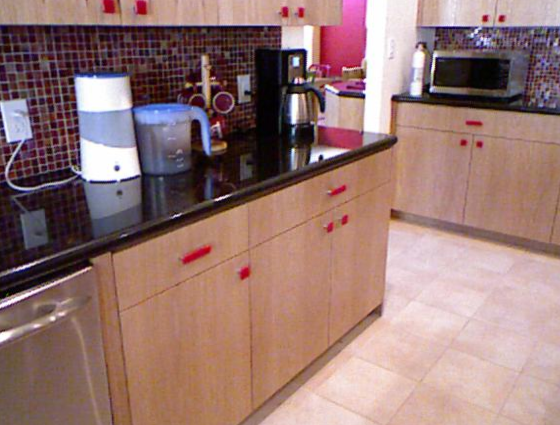

Question: what is on the right most side on the table
Answer: coffee_machine (Label: 126)
Predicted Answer:	 cup
No. of trainable parameters:	212,121,926


In [ ]:
def number_of_trainable_parameters(model):
    num_params = 0
    for p in model.parameters():
        if p.requires_grad:
            num_params += p.numel()
    print("No. of trainable parameters:\t{0:,}".format(num_params))

for i in range(1200,1205):
    dataset_example(train_data=False, example_id=i)
    print("Predicted Answer:\t", all_answers[preds[i-1200]])

number_of_trainable_parameters(model)

#Inference

In [ ]:
img = Image.open('demo2.jpeg')
new_image = img.resize((560, 425))
new_image.save('rezised_image_mukesh.png')
display(new_image)

In [ ]:
import argparse
import yaml
config_path='/content/drive/MyDrive/VQA/params.yaml'
# img_path= '/content/drive/MyDrive/VQA/dataset/images/image1.png'
# question = 'what is on the left side of the white oven on the floor and on right side of the blue armchair'
img_path= 'rezised_image_mukesh.png'
question = 'what is the black object on the right of white laptop'

with open(config_path) as conf_file:
    config = yaml.safe_load(conf_file)
question = question.replace("?", "").strip()                    # remove the question mark (if present) & extra spaces before tokenizing

model.eval()

tokenizer = AutoTokenizer.from_pretrained(config["model"]["text_encoder"])
featurizer = AutoFeatureExtractor.from_pretrained(config["model"]["image_encoder"])
encoded_text = tokenizer(text=[question],padding='longest',max_length=24,truncation=True,return_tensors='pt',return_token_type_ids=True,return_attention_mask=True)
processed_images = featurizer(images=[Image.open(img_path).convert('RGB')],return_tensors="pt")


# Obtain the prediction from the model
input_ids = encoded_text['input_ids'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
pixel_values = processed_images['pixel_values'].to(device)
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

# Obtain the answer from the answer space
preds = output["predicted_labels"].argmax(axis=-1).cpu().numpy()
answer = all_answers[preds[0]]
image = Image.open(img_path)
display(image)
print("Question: " + str(question))
print("Answer: " + str(answer))

#Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import os
import argparse
import yaml
from typing import Text
import logging

def process_dataset(path_to_data):
    with open(path_to_data) as config_file:
        config = yaml.safe_load(config_file)

    img_pattern = re.compile("( (in |on |of )?(the |this )?(img\d*) \?)")

    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["all_qa_pairs_file"])) as file:
        qa_data = [line.replace("\n", "") for line in file.readlines()]
    logging.info("All question-answer pairs loaded")

    dataframe = pd.DataFrame({config["data"]["question_col"]: [], config["data"]["answer_col"]: [], config["data"]["image_col"]:[]})

    logging.info("Processing raw question-answer pairs...")
    for i in range(0, len(qa_data), 2):
        image_id = img_pattern.findall(qa_data[i])[0][3]
        question = qa_data[i].replace(img_pattern.findall(qa_data[i])[0][0], "")
        record = {
            config["data"]["question_col"]: question,
            config["data"]["answer_col"]: qa_data[i+1],
            config["data"]["image_col"]: image_id,
        }
        dataframe = dataframe.append(record, ignore_index=True)

    all_answers = []
    for answer in dataframe[config["data"]["answer_col"]].to_list():
        if "," not in answer:
            all_answers = all_answers + [answer]
        else:
            all_answers = all_answers + answer.replace(" ", "").split(",")

    all_answers = list(set(all_answers))
    all_answers.sort()
    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["all_answers_file"]), "w") as f:
        f.writelines("\n".join(all_answers))

    logging.info("Splitting into train and eval sets")
    train_df, eval_df = train_test_split(dataframe, test_size=0.2, random_state=42)

    train_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["train_dataset_file"]), index=None)
    eval_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["eval_dataset_file"]), index=None)


Project Prese